---
## 4. Random Forest + Feature Importance

**Kỹ thuật**: Random Forest Classifier (Embedded Feature Selection)

**Mục đích**: Phân loại và xếp hạng tầm quan trọng features

In [60]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score

# Plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

In [61]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/DAV/labeled_data_final.csv')

In [62]:
# Bước 1.1: Xác định các cột FPED cần chuẩn hóa
print("=" * 60)
print("BƯỚC 1: FEATURE ENGINEERING (Per 100kcal)")
print("=" * 60)

# Loại bỏ các cột không phải features và Target Leakage
exclude_cols = ['ID', 'DESCRIPTION', 'Energy (kcal)', 'Energy_Factor',
                'NRF9.3_Score', 'Label_Value', 'Label_Text', 'y',
                'Total_NRF9', 'Total_LIM', 'WWEIA Category number', 'WWEIA Category description']

# Loại bỏ các cột dinh dưỡng (Nutrients) - chỉ giữ FPED
exclude_keywords = ['Protein', 'Fiber', 'Vitamin', 'Calcium', 'Iron', 'Magnesium',
                    'Potassium', 'Sodium', 'Fatty', 'Sugar', 'Score_']

# Lấy các cột FPED
fped_cols = [c for c in df.columns if c not in exclude_cols
             and df[c].dtype in ['float64', 'int64']
             and not any(k in c for k in exclude_keywords)]

# Loại bỏ các cột TOTAL để tránh multicollinearity
fped_cols = [c for c in fped_cols if 'TOTAL' not in c]

print(f"\nSố features FPED được chọn: {len(fped_cols)}")
print(f"\nDanh sách features:")
for i, col in enumerate(fped_cols, 1):
    print(f"  {i:2d}. {col}")

BƯỚC 1: FEATURE ENGINEERING (Per 100kcal)

Số features FPED được chọn: 29

Danh sách features:
   1. F_CITMLB (cup eq.)
   2. F_OTHER (cup eq.)
   3. F_JUICE (cup eq.)
   4. V_DRKGR (cup eq.)
   5. V_REDOR_TOMATO (cup eq.)
   6. V_REDOR_OTHER (cup eq.)
   7. V_STARCHY_POTATO (cup eq.)
   8. V_STARCHY_OTHER (cup eq.)
   9. V_OTHER (cup eq.)
  10. V_LEGUMES (cup eq.)
  11. G_WHOLE (oz. eq.)
  12. G_REFINED (oz. eq.)
  13. PF_MEAT (oz. eq.)
  14. PF_CUREDMEAT (oz. eq.)
  15. PF_ORGAN (oz. eq.)
  16. PF_POULT (oz. eq.)
  17. PF_SEAFD_HI (oz. eq.)
  18. PF_SEAFD_LOW (oz. eq.)
  19. PF_EGGS (oz. eq.)
  20. PF_SOY (oz. eq.)
  21. PF_NUTSDS (oz. eq.)
  22. PF_LEGUMES (oz. eq.)
  23. D_MILK (cup eq.)
  24. D_YOGURT (cup eq.)
  25. D_CHEESE (cup eq.)
  26. OILS (grams)
  27. SOLID_FATS (grams)
  28. ADD_SUGARS (tsp. eq.)
  29. A_DRINKS (no. of drinks)


In [63]:
# Bước 1.2: Chuẩn hóa per 100kcal (GIỐNG NHƯ ORDINAL REGRESSION)
# Tính mẫu số năng lượng (Sàn 5 kcal để tránh chia cho 0)
energy_denom = df['Energy (kcal)'].clip(lower=5)
scaling_factor = 100 / energy_denom

# Scale tất cả features
scaled_features = []
for col in fped_cols:
    new_col_name = col + '_100kcal'
    df[new_col_name] = df[col] * scaling_factor
    scaled_features.append(new_col_name)
# Tạo tên ngắn gọn cho display
short_names = [f.replace('_100kcal', '').replace(' (cup eq.)', '').replace(' (oz. eq.)', '')
               .replace(' (grams)', '').replace(' (tsp. eq.)', '') for f in scaled_features]

In [64]:
# Bước 2: Định nghĩa X và y
print("=" * 60)
print("BƯỚC 2: CHUẨN BỊ DATA")
print("=" * 60)

X = df[scaled_features]
y = df['Label_Value']  # 0=Bad, 1=Medium, 2=Good

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nLabel distribution:")
print(y.value_counts().sort_index())

BƯỚC 2: CHUẨN BỊ DATA

X shape: (7080, 29)
y shape: (7080,)

Label distribution:
Label_Value
0    2375
1    4044
2     661
Name: count, dtype: int64


In [65]:
# Train/Test Split với Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 5664 samples
Test set: 1416 samples


In [66]:
# Bước 3: Huấn luyện Random Forest
print("=" * 60)
print("BƯỚC 3: HUẤN LUYỆN RANDOM FOREST")
print("=" * 60)

rf_model = RandomForestClassifier(
    n_estimators=100,      # Số cây
    max_depth=10,          # Độ sâu tối đa
    min_samples_split=5,   # Số mẫu tối thiểu để split
    min_samples_leaf=2,    # Số mẫu tối thiểu ở leaf
    random_state=42,
    n_jobs=-1              # Dùng tất cả CPU cores
)

rf_model.fit(X_train, y_train)
print("\nRandom Forest trained successfully!")

BƯỚC 3: HUẤN LUYỆN RANDOM FOREST

Random Forest trained successfully!


In [67]:
# Bước 4: Đánh giá
print("=" * 60)
print("BƯỚC 4: ĐÁNH GIÁ MÔ HÌNH")
print("=" * 60)

# Predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

# Cross-Validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation (5-fold):")
print(f"   Mean Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

BƯỚC 4: ĐÁNH GIÁ MÔ HÌNH

Test Accuracy: 0.7931 (79.3%)

Cross-Validation (5-fold):
   Mean Accuracy: 0.6831 ± 0.0602


In [68]:
# Classification Report
print("\nClassification Report:")
print("-" * 60)
print(classification_report(y_test, y_pred, target_names=['Bad', 'Medium', 'Good']))


Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

         Bad       0.87      0.65      0.75       475
      Medium       0.77      0.93      0.84       809
        Good       0.80      0.42      0.55       132

    accuracy                           0.79      1416
   macro avg       0.81      0.67      0.71      1416
weighted avg       0.80      0.79      0.78      1416



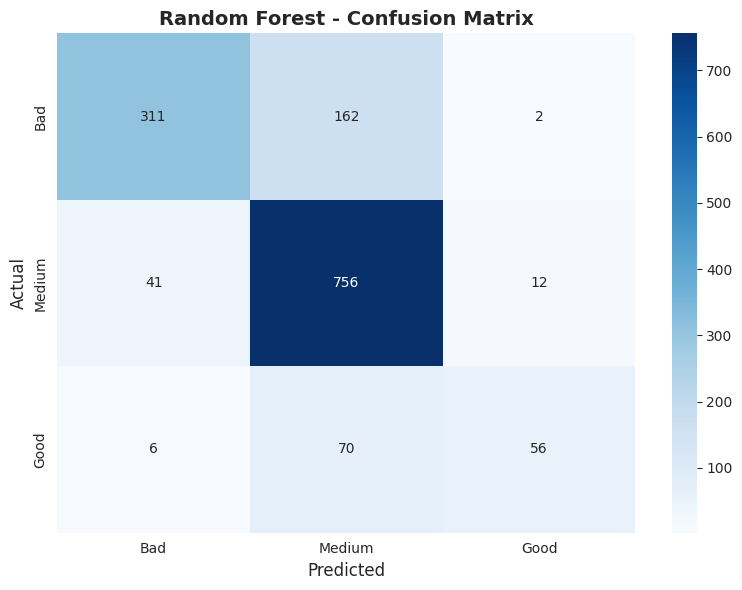

Đã lưu: rf_confusion_matrix.png


In [69]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad', 'Medium', 'Good'],
            yticklabels=['Bad', 'Medium', 'Good'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: rf_confusion_matrix.png")

In [70]:
# Bước 5: Feature Importance
print("=" * 60)
print("BƯỚC 5: FEATURE IMPORTANCE")
print("=" * 60)

feature_importance = pd.DataFrame({
    'Feature': scaled_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features quan trọng nhất:")
print("-" * 60)
for i, row in feature_importance.head(15).iterrows():
    bar = "█" * int(row['Importance'] * 100)
    # Bỏ đuôi _100kcal để hiển thị gọn
    name = row['Feature'].replace('_100kcal', '')
    print(f"{name[:35]:35s} | {row['Importance']:.4f} | {bar}")

BƯỚC 5: FEATURE IMPORTANCE

Top 15 Features quan trọng nhất:
------------------------------------------------------------
ADD_SUGARS (tsp. eq.)               | 0.2254 | ██████████████████████
SOLID_FATS (grams)                  | 0.1929 | ███████████████████
V_DRKGR (cup eq.)                   | 0.0851 | ████████
V_OTHER (cup eq.)                   | 0.0730 | ███████
V_REDOR_OTHER (cup eq.)             | 0.0535 | █████
OILS (grams)                        | 0.0374 | ███
PF_CUREDMEAT (oz. eq.)              | 0.0374 | ███
D_MILK (cup eq.)                    | 0.0359 | ███
PF_EGGS (oz. eq.)                   | 0.0322 | ███
G_REFINED (oz. eq.)                 | 0.0310 | ███
G_WHOLE (oz. eq.)                   | 0.0287 | ██
PF_SEAFD_LOW (oz. eq.)              | 0.0269 | ██
V_REDOR_TOMATO (cup eq.)            | 0.0251 | ██
D_CHEESE (cup eq.)                  | 0.0184 | █
F_JUICE (cup eq.)                   | 0.0147 | █


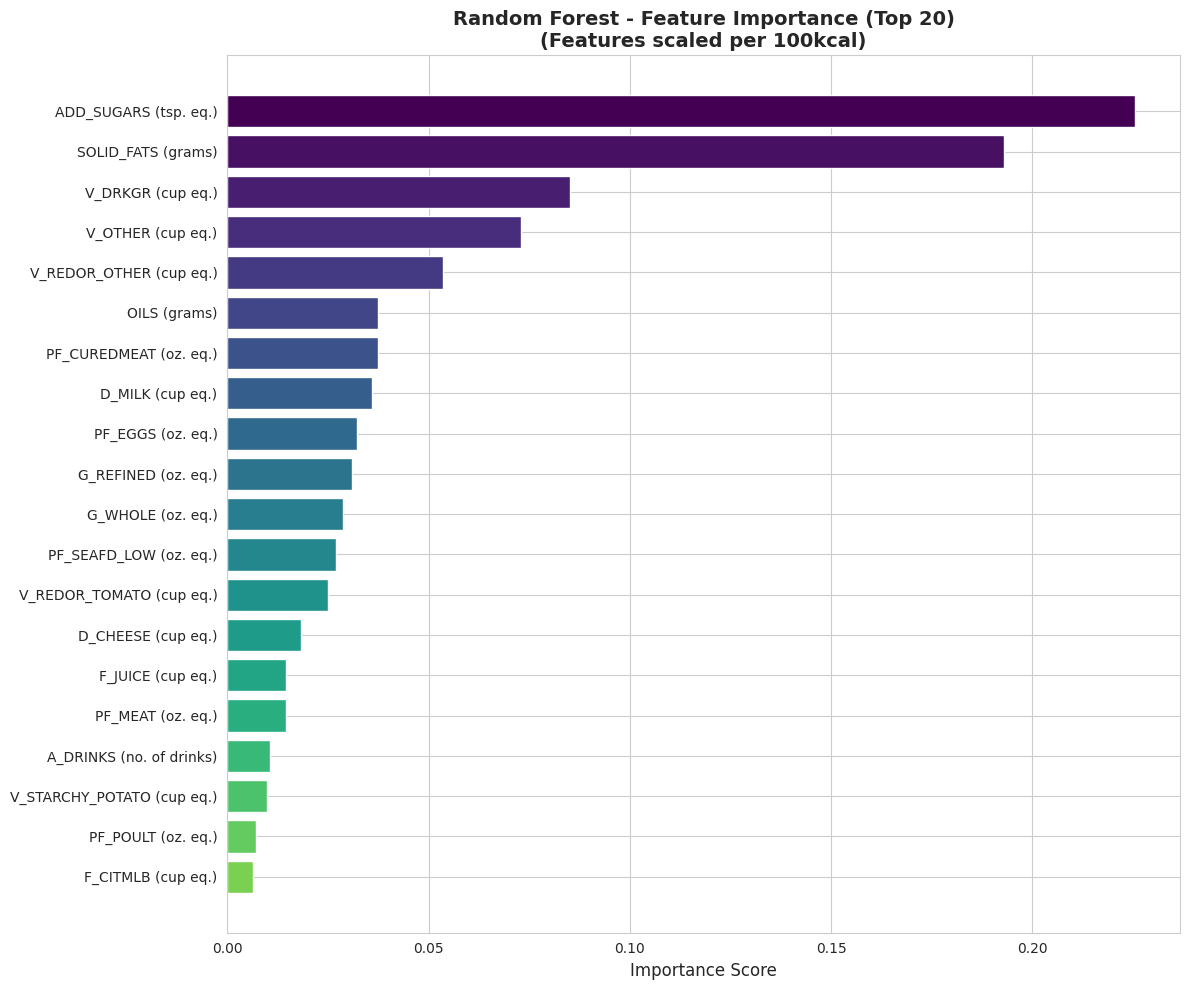

Đã lưu: rf_feature_importance.png


In [71]:
# Visualization
plt.figure(figsize=(12, 10))
top_20 = feature_importance.head(20)
colors = plt.cm.viridis(np.linspace(0, 0.8, len(top_20)))

# Bỏ đuôi _100kcal để hiển thị gọn
labels = [f.replace('_100kcal', '') for f in top_20['Feature']]

plt.barh(range(len(top_20)), top_20['Importance'], color=colors)
plt.yticks(range(len(top_20)), labels)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Random Forest - Feature Importance (Top 20)\n(Features scaled per 100kcal)',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: rf_feature_importance.png")

## 5.  Ordinal Logistic Regression (Deep Dive)

In [72]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [73]:
# Bước 2: Định nghĩa X và y
print("=" * 60)
print("📋 BƯỚC 2: CHUẨN BỊ DATA")
print("=" * 60)

X = df[scaled_features]
y = df['Label_Value']  # 0=Bad, 1=Medium, 2=Good

# Standardize features (quan trọng cho Logistic Regression)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=scaled_features, index=df.index)

print(f"\n✅ X shape: {X_scaled.shape}")
print(f"✅ y shape: {y.shape}")

📋 BƯỚC 2: CHUẨN BỊ DATA

✅ X shape: (7080, 29)
✅ y shape: (7080,)


In [74]:
# Train/Test Split với Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Train set: {len(X_train)} samples")
print(f"✅ Test set: {len(X_test)} samples")

✅ Train set: 5664 samples
✅ Test set: 1416 samples


In [75]:
# Bước 3: Huấn luyện Logistic Regression
print("=" * 60)
print("📊 BƯỚC 3: HUẤN LUYỆN MULTINOMIAL LOGISTIC REGRESSION")
print("=" * 60)

lr_model = LogisticRegression(
    multi_class='multinomial',  # Multinomial (không phải One-vs-Rest)
    solver='lbfgs',             # Optimizer
    max_iter=1000,              # Số iterations tối đa
    random_state=42,
    C=1.0                       # Regularization strength
)

lr_model.fit(X_train, y_train)
print("\n✅ Multinomial Logistic Regression trained successfully!")

📊 BƯỚC 3: HUẤN LUYỆN MULTINOMIAL LOGISTIC REGRESSION

✅ Multinomial Logistic Regression trained successfully!


In [76]:
# Bước 4: Đánh giá
print("=" * 60)
print("📊 BƯỚC 4: ĐÁNH GIÁ MÔ HÌNH")
print("=" * 60)

# Predictions
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Test Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

# Cross-Validation
cv_scores = cross_val_score(lr_model, X_scaled, y, cv=5, scoring='accuracy')
print(f"\n🔄 Cross-Validation (5-fold):")
print(f"   Mean Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

📊 BƯỚC 4: ĐÁNH GIÁ MÔ HÌNH

🎯 Test Accuracy: 0.8178 (81.8%)

🔄 Cross-Validation (5-fold):
   Mean Accuracy: 0.7136 ± 0.0864


In [77]:
# Classification Report
print("\n📊 Classification Report:")
print("-" * 60)
print(classification_report(y_test, y_pred, target_names=['Bad', 'Medium', 'Good']))


📊 Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

         Bad       0.85      0.75      0.79       475
      Medium       0.81      0.91      0.85       809
        Good       0.79      0.53      0.63       132

    accuracy                           0.82      1416
   macro avg       0.81      0.73      0.76      1416
weighted avg       0.82      0.82      0.81      1416



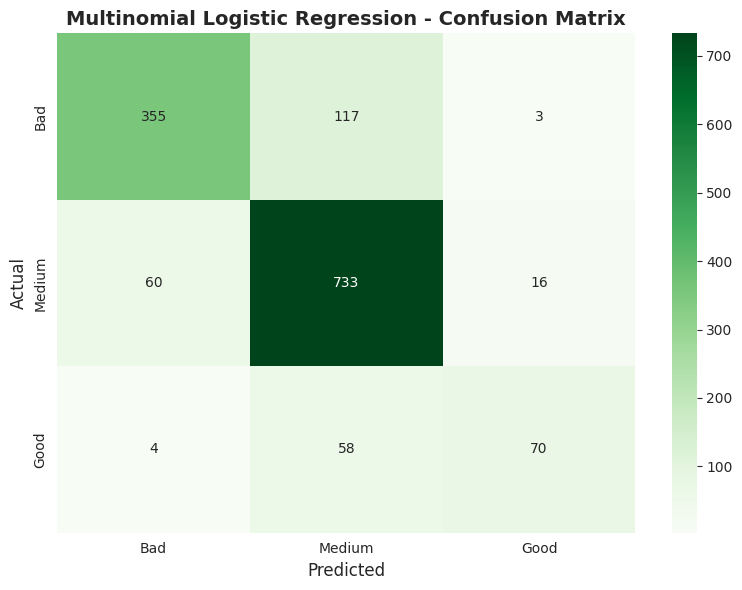

💾 Đã lưu: lr_confusion_matrix.png


In [78]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Bad', 'Medium', 'Good'],
            yticklabels=['Bad', 'Medium', 'Good'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Multinomial Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/lr_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Đã lưu: lr_confusion_matrix.png")

In [79]:
# Bước 5: Phân tích Coefficients
print("=" * 60)
print("📊 BƯỚC 5: FEATURE COEFFICIENTS")
print("=" * 60)

# Coefficients cho từng class
coef_df = pd.DataFrame(
    lr_model.coef_.T,
    columns=['Coef_Bad', 'Coef_Medium', 'Coef_Good'],
    index=scaled_features
)

# Thêm tên ngắn gọn
coef_df['Feature'] = [f.replace('_100kcal', '') for f in scaled_features]

# Sắp xếp theo coefficient của Good class
coef_df = coef_df.sort_values('Coef_Good', ascending=False)

print("\n📊 Top 10 Features TÁC ĐỘNG TÍCH CỰC đến 'Good':")
print("-" * 60)
print(coef_df[['Feature', 'Coef_Good']].head(10).to_string(index=False))

📊 BƯỚC 5: FEATURE COEFFICIENTS

📊 Top 10 Features TÁC ĐỘNG TÍCH CỰC đến 'Good':
------------------------------------------------------------
                 Feature  Coef_Good
       V_DRKGR (cup eq.)   2.572897
 V_REDOR_OTHER (cup eq.)   0.877340
       V_OTHER (cup eq.)   0.704168
V_REDOR_TOMATO (cup eq.)   0.485430
       F_JUICE (cup eq.)   0.391378
        D_MILK (cup eq.)   0.294778
      F_CITMLB (cup eq.)   0.270384
  PF_SEAFD_LOW (oz. eq.)   0.226514
       PF_EGGS (oz. eq.)   0.210593
      D_CHEESE (cup eq.)   0.183216


In [80]:
print("\n📊 Top 10 Features TÁC ĐỘNG TIÊU CỰC đến 'Good':")
print("-" * 60)
print(coef_df[['Feature', 'Coef_Good']].tail(10).to_string(index=False))


📊 Top 10 Features TÁC ĐỘNG TIÊU CỰC đến 'Good':
------------------------------------------------------------
                 Feature  Coef_Good
     V_LEGUMES (cup eq.)  -0.156985
A_DRINKS (no. of drinks)  -0.179617
      PF_POULT (oz. eq.)  -0.264205
            OILS (grams)  -0.424090
     G_REFINED (oz. eq.)  -0.480535
   ADD_SUGARS (tsp. eq.)  -0.518611
      D_YOGURT (cup eq.)  -0.543332
       PF_MEAT (oz. eq.)  -0.602471
  PF_CUREDMEAT (oz. eq.)  -0.678003
      SOLID_FATS (grams)  -0.808830


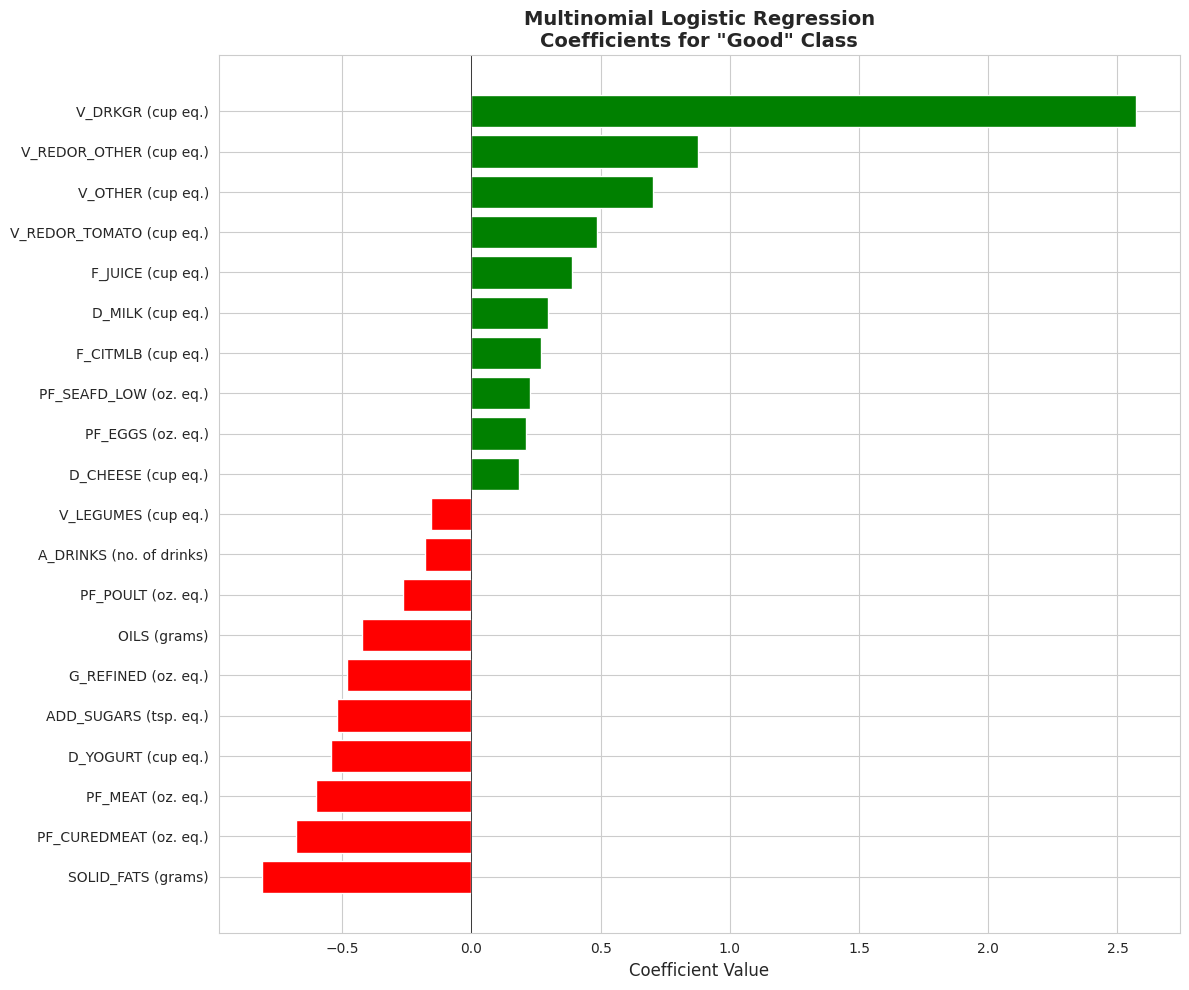

💾 Đã lưu: lr_coefficients.png


In [81]:
# Visualization: Coefficients cho Good class
plt.figure(figsize=(12, 10))

# Lấy top 10 positive và top 10 negative
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)
to_plot = pd.concat([top_pos, top_neg])

colors = ['green' if x > 0 else 'red' for x in to_plot['Coef_Good']]
plt.barh(range(len(to_plot)), to_plot['Coef_Good'], color=colors)
plt.yticks(range(len(to_plot)), to_plot['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.title('Multinomial Logistic Regression\nCoefficients for "Good" Class',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/lr_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Đã lưu: lr_coefficients.png")

In [82]:
# Tính Odds Ratio = exp(coefficient)
print("=" * 60)
print("📊 BƯỚC 6: ODDS RATIO")
print("=" * 60)

coef_df['OR_Good'] = np.exp(coef_df['Coef_Good'])

print("\n📊 Odds Ratio cho 'Good' class:")
print("-" * 60)
print("(OR > 1: Tăng khả năng Good, OR < 1: Giảm khả năng Good)")
print()

# Top features tăng khả năng Good
print("🟢 Features TĂNG khả năng Good (OR > 1):")
top_or = coef_df.nlargest(10, 'OR_Good')[['Feature', 'OR_Good']]
for i, row in top_or.iterrows():
    print(f"   • {row['Feature']:30s} OR = {row['OR_Good']:.3f}")

print("\n🔴 Features GIẢM khả năng Good (OR < 1):")
bot_or = coef_df.nsmallest(10, 'OR_Good')[['Feature', 'OR_Good']]
for i, row in bot_or.iterrows():
    print(f"   • {row['Feature']:30s} OR = {row['OR_Good']:.3f}")

📊 BƯỚC 6: ODDS RATIO

📊 Odds Ratio cho 'Good' class:
------------------------------------------------------------
(OR > 1: Tăng khả năng Good, OR < 1: Giảm khả năng Good)

🟢 Features TĂNG khả năng Good (OR > 1):
   • V_DRKGR (cup eq.)              OR = 13.104
   • V_REDOR_OTHER (cup eq.)        OR = 2.404
   • V_OTHER (cup eq.)              OR = 2.022
   • V_REDOR_TOMATO (cup eq.)       OR = 1.625
   • F_JUICE (cup eq.)              OR = 1.479
   • D_MILK (cup eq.)               OR = 1.343
   • F_CITMLB (cup eq.)             OR = 1.310
   • PF_SEAFD_LOW (oz. eq.)         OR = 1.254
   • PF_EGGS (oz. eq.)              OR = 1.234
   • D_CHEESE (cup eq.)             OR = 1.201

🔴 Features GIẢM khả năng Good (OR < 1):
   • SOLID_FATS (grams)             OR = 0.445
   • PF_CUREDMEAT (oz. eq.)         OR = 0.508
   • PF_MEAT (oz. eq.)              OR = 0.547
   • D_YOGURT (cup eq.)             OR = 0.581
   • ADD_SUGARS (tsp. eq.)          OR = 0.595
   • G_REFINED (oz. eq.)            OR = 

#SHAP


In [83]:
 !pip install shap

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')
import shap
shap.initjs()

In [85]:
print("=" * 60)
print("💡 SHAP - RANDOM FOREST")
print("=" * 60)

# Sample để tính nhanh
X_sample = X_test.iloc[:300] if len(X_test) > 300 else X_test

# TreeExplainer cho Random Forest
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_sample)

print(f"✅ SHAP values computed for {len(X_sample)} samples!")

💡 SHAP - RANDOM FOREST
✅ SHAP values computed for 300 samples!


<Figure size 1200x1000 with 0 Axes>

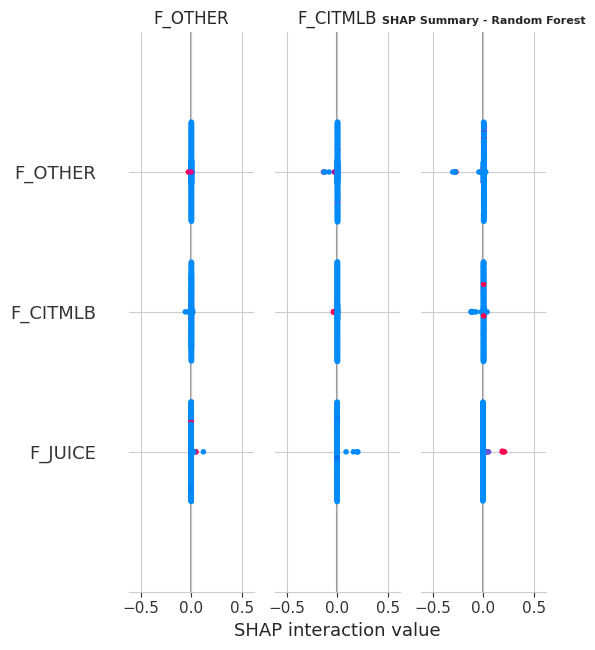

💾 Đã lưu: shap_rf_summary.png


In [87]:
# Summary Plot - Random Forest (All classes)
plt.figure(figsize=(12, 10))
shap.summary_plot(rf_shap_values, X_sample, feature_names=short_names,
                  class_names=['Bad', 'Medium', 'Good'], show=False)
plt.title('SHAP Summary - Random Forest', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/shap_rf_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Đã lưu: shap_rf_summary.png")

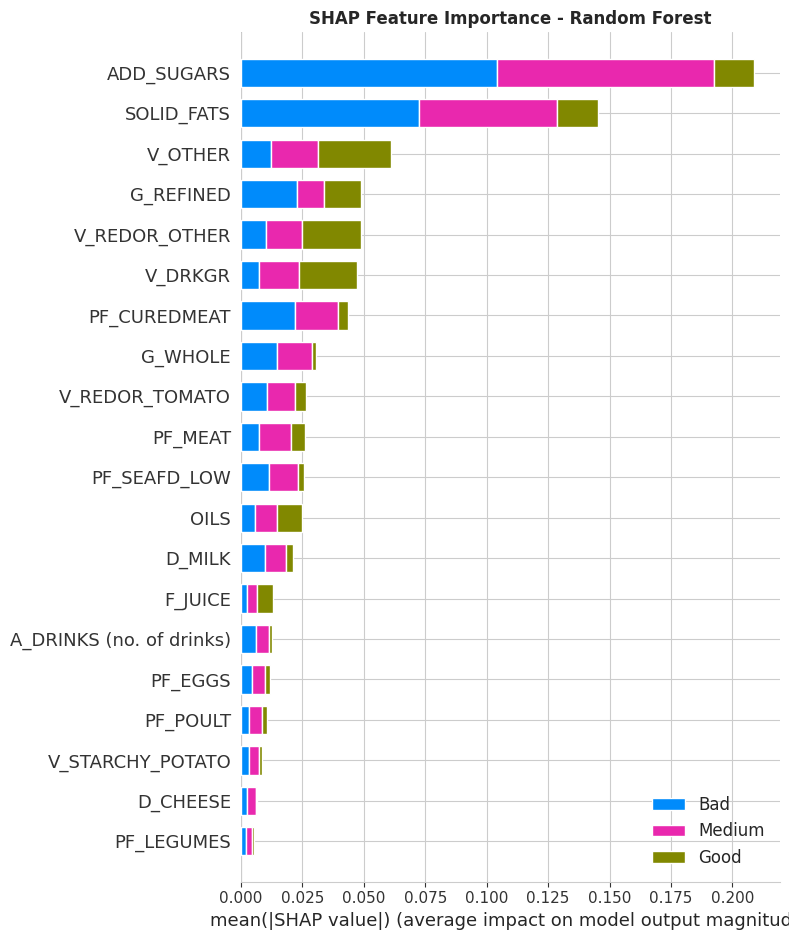

💾 Đã lưu: shap_rf_bar.png


In [88]:
# Bar Plot - Random Forest
plt.figure(figsize=(12, 8))
shap.summary_plot(rf_shap_values, X_sample, feature_names=short_names,
                  plot_type="bar", class_names=['Bad', 'Medium', 'Good'], show=False)
plt.title('SHAP Feature Importance - Random Forest', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/shap_rf_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Đã lưu: shap_rf_bar.png")

<Figure size 1200x800 with 0 Axes>

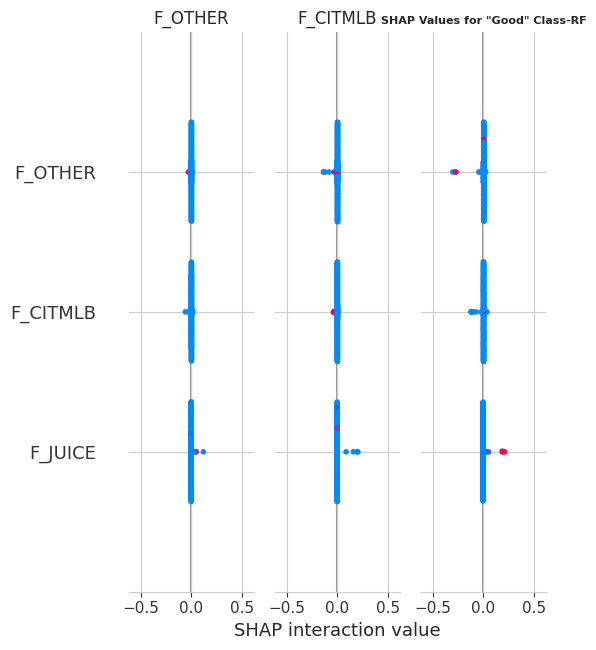

💾 Đã lưu: shap_rf_good.png


In [94]:
# SHAP cho class "Good" (class 2)
plt.figure(figsize=(12, 8))
# Kiểm tra cấu trúc và chọn đúng
if isinstance(rf_shap_values, list):
    # Cấu trúc cũ: list of arrays
    shap_good = rf_shap_values[2]
else:
    # Cấu trúc mới: single array
    shap_good = rf_shap_values
shap.summary_plot(shap_good, X_sample, feature_names=short_names, show=False)
plt.title('SHAP Values for "Good" Class-RF', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/shap_rf_good.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Đã lưu: shap_rf_good.png")

---
##  SHAP Analysis - Logistic Regression

In [95]:
# SHAP cho Logistic Regression
print("=" * 60)
print("💡 SHAP - LOGISTIC REGRESSION")
print("=" * 60)

# LinearExplainer cho Logistic Regression
lr_explainer = shap.LinearExplainer(lr_model, X_train, feature_perturbation="interventional")
lr_shap_values = lr_explainer.shap_values(X_sample)

print(f"✅ SHAP values computed for {len(X_sample)} samples!")

💡 SHAP - LOGISTIC REGRESSION
✅ SHAP values computed for 300 samples!


<Figure size 1200x1000 with 0 Axes>

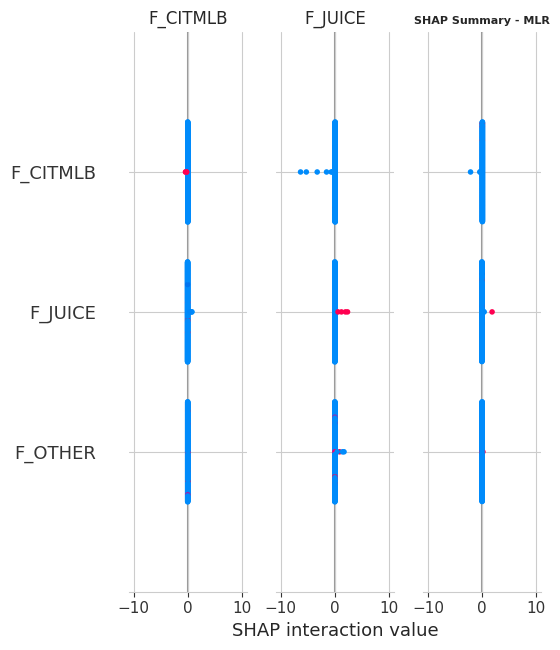

💾 Đã lưu: shap_lr_summary.png


In [98]:
# Summary Plot - Logistic Regression (All classes)
plt.figure(figsize=(12, 10))
shap.summary_plot(lr_shap_values, X_sample, feature_names=short_names,
                  class_names=['Bad', 'Medium', 'Good'], show=False)
plt.title('SHAP Summary - MLR', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/shap_lr_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Đã lưu: shap_lr_summary.png")

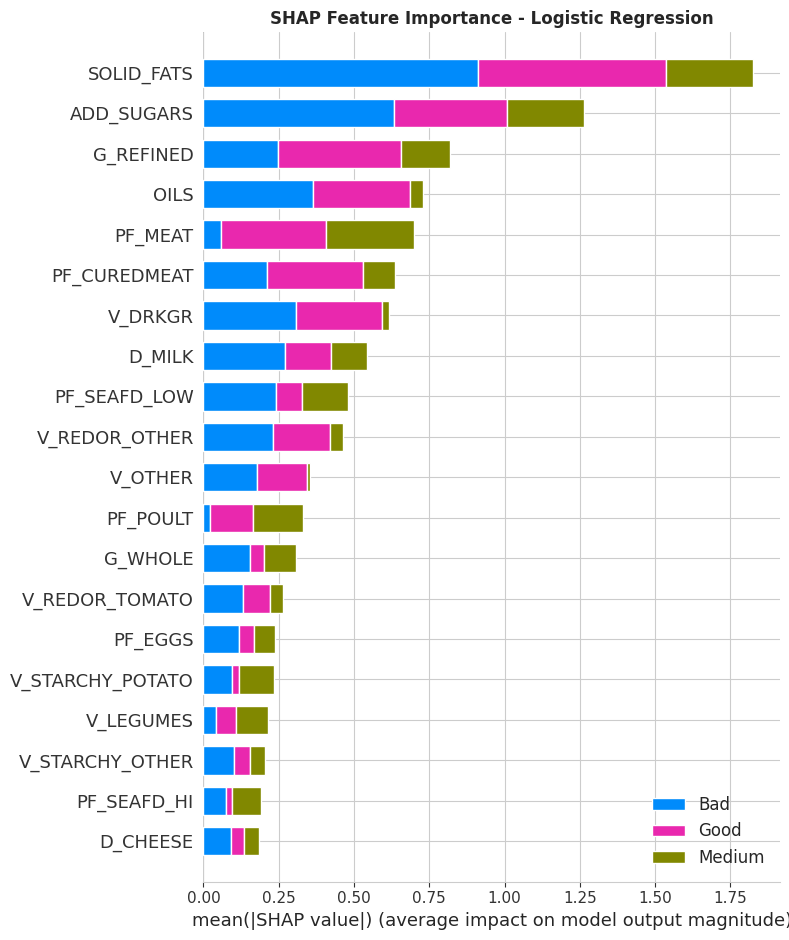

💾 Đã lưu: shap_lr_bar.png


In [99]:
# Bar Plot - Logistic Regression
plt.figure(figsize=(12, 8))
shap.summary_plot(lr_shap_values, X_sample, feature_names=short_names,
                  plot_type="bar", class_names=['Bad', 'Medium', 'Good'], show=False)
plt.title('SHAP Feature Importance - Logistic Regression', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_lr_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Đã lưu: shap_lr_bar.png")

In [100]:
# Tính mean absolute SHAP cho mỗi model
print("=" * 60)
print("📊 SO SÁNH SHAP FEATURE IMPORTANCE")
print("=" * 60)

# RF: mean absolute SHAP across all classes
rf_mean_shap = np.mean([np.abs(rf_shap_values[i]).mean(axis=0) for i in range(3)], axis=0)

# LR: mean absolute SHAP across all classes
lr_mean_shap = np.mean([np.abs(lr_shap_values[i]).mean(axis=0) for i in range(3)], axis=0)

# So sánh
comparison_df = pd.DataFrame({
    'Feature': short_names,
    'RF_SHAP': rf_mean_shap,
    'LR_SHAP': lr_mean_shap
})

# Rank
comparison_df['RF_Rank'] = comparison_df['RF_SHAP'].rank(ascending=False).astype(int)
comparison_df['LR_Rank'] = comparison_df['LR_SHAP'].rank(ascending=False).astype(int)
comparison_df = comparison_df.sort_values('RF_SHAP', ascending=False)

print("\n📊 Top 15 Features (by RF SHAP):")
print("-" * 70)
print(comparison_df.head(15).to_string(index=False))

📊 SO SÁNH SHAP FEATURE IMPORTANCE


ValueError: All arrays must be of the same length

In [101]:
# ============================================================
# 🍎 TEST VỚI MÓN ĂN TỰ TẠO
# ============================================================

print("\n" + "=" * 70)
print("🍎 TEST VỚI MÓN ĂN TỰ TẠO")
print("=" * 70)

# Tạo một món ăn giả định (tất cả = 0 trước)
custom_food = {col: 0.0 for col in X.columns}

# --- Ví dụ 1: Salad rau xanh (dự đoán Good) ---
custom_food_good = custom_food.copy()
custom_food_good['V_DRKGR (cup eq.)_100kcal'] = 3.0  # Nhiều rau xanh
custom_food_good['SOLID_FATS (grams)_100kcal'] = 0.1  # Ít chất béo
custom_food_good['ADD_SUGARS (tsp. eq.)_100kcal'] = 0.0  # Không đường

X_good = pd.DataFrame([custom_food_good])
print("\n🥗 Món 1: Salad rau xanh")
print(f"   LR: {labels[lr_model.predict(X_good)[0]]} - Prob: {lr_model.predict_proba(X_good)[0]}")
print(f"   RF: {labels[rf_model.predict(X_good)[0]]} - Prob: {rf_model.predict_proba(X_good)[0]}")

# --- Ví dụ 2: Nước ngọt (dự đoán Bad) ---
custom_food_bad = custom_food.copy()
custom_food_bad['ADD_SUGARS (tsp. eq.)_100kcal'] = 5.0  # Nhiều đường
custom_food_bad['SOLID_FATS (grams)_100kcal'] = 0.0  # Không chất béo
custom_food_bad['V_DRKGR (cup eq.)_100kcal'] = 0.0  # Không rau

X_bad = pd.DataFrame([custom_food_bad])
print("\n🥤 Món 2: Nước ngọt")
print(f"   LR: {labels[lr_model.predict(X_bad)[0]]} - Prob: {lr_model.predict_proba(X_bad)[0]}")
print(f"   RF: {labels[rf_model.predict(X_bad)[0]]} - Prob: {rf_model.predict_proba(X_bad)[0]}")

# --- Ví dụ 3: Bánh mì kẹp thịt (dự đoán Medium) ---
custom_food_med = custom_food.copy()
custom_food_med['G_REFINED (oz. eq.)_100kcal'] = 1.5  # Bánh mì
custom_food_med['PF_MEAT (oz. eq.)_100kcal'] = 1.0  # Thịt
custom_food_med['SOLID_FATS (grams)_100kcal'] = 1.0  # Chất béo vừa

X_med = pd.DataFrame([custom_food_med])
print("\n🍔 Món 3: Bánh mì kẹp thịt")
print(f"   LR: {labels[lr_model.predict(X_med)[0]]} - Prob: {lr_model.predict_proba(X_med)[0]}")
print(f"   RF: {labels[rf_model.predict(X_med)[0]]} - Prob: {rf_model.predict_proba(X_med)[0]}")


🍎 TEST VỚI MÓN ĂN TỰ TẠO

🥗 Món 1: Salad rau xanh
   LR: V_DRKGR (cup eq.) - Prob: [5.83753379e-07 2.12789921e-02 9.78720424e-01]
   RF: V_DRKGR (cup eq.) - Prob: [0.03153835 0.12076642 0.84769523]

🥤 Món 2: Nước ngọt
   LR: ADD_SUGARS (tsp. eq.) - Prob: [9.88506202e-01 1.12930491e-02 2.00748968e-04]
   RF: ADD_SUGARS (tsp. eq.) - Prob: [0.761899   0.19982707 0.03827394]

🍔 Món 3: Bánh mì kẹp thịt
   LR: SOLID_FATS (grams) - Prob: [0.40824314 0.58989526 0.0018616 ]
   RF: SOLID_FATS (grams) - Prob: [0.26762059 0.69447536 0.03790405]
